In [ ]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
from torch.optim import SGD, lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis

from dataloaders.cifar10 import cifar10_dataloaders
from dataloaders.cifar100 import cifar100_dataloaders
from dataloaders.svhn import svhn_dataloaders
from dataloaders.stl10 import stl10_dataloaders

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU') if str(device) == "cuda:0" else print('GPU not Detected - CPU Selected')
print(f"GPUs Count: {torch.cuda.device_count()}")

GPU
GPUs Count: 1


In [ ]:
my_train_batch_size = 128
DATASET = 'fashion_mnist'

In [ ]:
if DATASET == 'cifar10':
    train_loader, val_loader, test_loader = cifar10_dataloaders(train_batch_size=my_train_batch_size, num_workers=2)
elif DATASET == 'cifar100':
    train_loader, val_loader, test_loader = cifar100_dataloaders(train_batch_size=my_train_batch_size, num_workers=2)
elif DATASET == 'svhn':
    train_loader, val_loader, test_loader = svhn_dataloaders(train_batch_size=my_train_batch_size, num_workers=2)
elif DATASET == 'stl10':
    train_loader, val_loader = stl10_dataloaders(train_batch_size=my_train_batch_size, num_workers=2)
elif DATASET == 'mnist':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = Subset(datasets.MNIST('./data', train=True, transform=transform, download=True), list(range(50000)))
    val_dataset = Subset(datasets.MNIST('./data', train=True, transform=transform, download=True), list(range(50000, 60000)))
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=my_train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

elif DATASET == 'emnist':
    my_split = 'letters'  # options: 'byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist'
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.EMNIST(root='./data', split=my_split, train=True, transform=transform, download=True)
    test_dataset = datasets.EMNIST(root='./data', split=my_split, train=False, download=True, transform=transform)

    train_dataset.targets -= 1    # Shift labels from 1-26 to 0-25
    test_dataset.targets -= 1     # Shift labels from 1-26 to 0-25
    
    train_loader = DataLoader(train_dataset, batch_size=my_train_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

elif DATASET == 'fashion_mnist':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))])
    train_dataset = Subset(datasets.FashionMNIST('./data', train=True, transform=transform, download=True), list(range(50000)))
    val_dataset = Subset(datasets.FashionMNIST('./data', train=True, transform=transform, download=True), list(range(50000, 60000)))
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=my_train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)    

In [98]:
len(train_loader), len(val_loader), len(test_loader)

(391, 100, 100)

In [ ]:
if DATASET == 'mnist' or DATASET == 'emnist' or DATASET == 'fashion_mnist':
    image_channels = 1
else:
    image_channels = 3

class BasicBlock(nn.Module):
    def __init__(self, in_planes, mid_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.conv2 = nn.Conv2d(mid_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        if stride != 1 or in_planes != out_planes:
            self.mismatch = True
            self.conv_sc = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
            self.bn_sc = nn.BatchNorm2d(out_planes)
        else:
            self.mismatch = False

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.mismatch:
            out = out + self.bn_sc(self.conv_sc(x))
        else:
            out = out + x
        out = F.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, input_channels = image_channels, num_classes = 10):
        super(ResNet34, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.blocks = nn.ModuleList([
            BasicBlock(64, 64, 64, stride=1),
            BasicBlock(64, 64, 64, stride=1),
            BasicBlock(64, 64, 64, stride=1),

            BasicBlock(64, 128, 128, stride=2),
            BasicBlock(128, 128, 128, stride=1),
            BasicBlock(128, 128, 128, stride=1),
            BasicBlock(128, 128, 128, stride=1),

            BasicBlock(128, 256, 256, stride=2),
            BasicBlock(256, 256, 256, stride=1),
            BasicBlock(256, 256, 256, stride=1),
            BasicBlock(256, 256, 256, stride=1),
            BasicBlock(256, 256, 256, stride=1),
            BasicBlock(256, 256, 256, stride=1),

            BasicBlock(256, 512, 512, stride=2),
            BasicBlock(512, 512, 512, stride=1),
            BasicBlock(512, 512, 512, stride=1),
            ])

        self.linear_1 = nn.Linear(64, num_classes)
        self.linear_2 = nn.Linear(64, num_classes)
        self.linear_3 = nn.Linear(64, num_classes)
        self.linear_4 = nn.Linear(128, num_classes)
        self.linear_5 = nn.Linear(128, num_classes)
        self.linear_6 = nn.Linear(128, num_classes)
        self.linear_7 = nn.Linear(128, num_classes)
        self.linear_8 = nn.Linear(256, num_classes)
        self.linear_9 = nn.Linear(256, num_classes)
        self.linear_10 = nn.Linear(256, num_classes)
        self.linear_11 = nn.Linear(256, num_classes)
        self.linear_12 = nn.Linear(256, num_classes)
        self.linear_13 = nn.Linear(256, num_classes)
        self.linear_14 = nn.Linear(512, num_classes)
        self.linear_15 = nn.Linear(512, num_classes)
        self.linear_16 = nn.Linear(512, num_classes)
        
    def forward(self, x, depth_level=16):      
        out = F.relu(self.bn1(self.conv1(x)))
        i = 0
        for block in self.blocks:
            i=i+1
            out = block(out)
            if i == depth_level:
                break
                        
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        
        if depth_level == 1:
            out = self.linear_1(out)
        elif depth_level == 2:
            out = self.linear_2(out)
        elif depth_level == 3:
            out = self.linear_3(out)
        elif depth_level == 4:
            out = self.linear_4(out)
        elif depth_level == 5:
            out = self.linear_5(out)
        elif depth_level == 6:
            out = self.linear_6(out)
        elif depth_level == 7:
            out = self.linear_7(out)
        elif depth_level == 8:
            out = self.linear_8(out)
        elif depth_level == 9:
            out = self.linear_9(out)
        elif depth_level == 10:
            out = self.linear_10(out)
        elif depth_level == 11:
            out = self.linear_11(out)
        elif depth_level == 12:
            out = self.linear_12(out)
        elif depth_level == 13:
            out = self.linear_13(out)
        elif depth_level == 14:
            out = self.linear_14(out)
        elif depth_level == 15:
            out = self.linear_15(out)
        elif depth_level == 16:
            out = self.linear_16(out)
        return out

model = ResNet34().to(device)
max_depth = 16   # Number of blocks (total depth levels)

### **Training Loop**

In [28]:
depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

#depths = [2,4,6,8,10,12,14,16]

In [29]:
####################################### Train Model Till Convergence
def warm_up(model, epochs, learning_rate, depths):
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    for epoch in range(1, epochs+1):
        model.train()
        requires_grad_(model, True)
        accs, losses = AverageMeter(), AverageMeter()
        i = 0
        for imgs, labels in train_loader:
            i+=1
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            for depth_level in sorted(depths, reverse=True):
                logits = model(imgs, depth_level)
                loss = torch.mean(F.cross_entropy(logits, labels, reduction='none'))
                accs.append((logits.argmax(1) == labels).float().mean().item() * 100)
                losses.append(loss.item())
                loss.backward()
            optimizer.step()
        train_str = f"Epoch: {epoch} | Loss: {losses.avg:.4f} | Accuracy: {accs.avg:.2f} %"
        print(train_str)
        scheduler.step()
    return model

In [ ]:
####################################### Train Model Till Convergence
def train_till_convergence(model, target_accuracy, tolerance = 0.5, initial_depth = 1, max_depth = max_depth, learning_rate = 0.01):
    depth_level = initial_depth
    fine_tune_flag = 0
    stopping_epochs = 23
    no_improvement = 0
    epoch_id = 0
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.6)

    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Stores average loss per epoch

    while(1):
        epoch_id += 1
        model.train()
        train_loss = 0
        iteration = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            iteration += 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
                        
            outputs = model(images, depth_level)
            loss = nn.CrossEntropyLoss()(outputs, labels)            
            loss.backward()           
            optimizer.step()                
            train_loss += loss.item() 
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()            
            total += labels.size(0)
                              
        train_loss /= len(train_loader)
        train_losses.append(train_loss) 
        train_acc = round((correct / total) * 100, 2)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(images, depth_level)
                
            loss = nn.CrossEntropyLoss()(outputs, labels)            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()            
            total += labels.size(0)
                    
        val_loss /= len(val_loader)
        val_loss = round(val_loss,4)
        val_losses.append(val_loss)
        val_acc = round((correct / total) * 100, 2)
        val_accs.append(val_acc)
        print(f"Epoch {epoch_id}: Train Loss = {train_loss:.4f}, Depth = {depth_level}, Validation Accuracy = {val_acc:.2f} %")
        
        if fine_tune_flag == 0:
            val_acc = round((correct / total) * 100, 1)
        else:
            val_acc = round((correct / total) * 100, 2)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"******* Best Validation Accuracy: {best_val_acc:.2f} %")
            no_improvement = 0
            torch.save(model.state_dict(), 'ODN_ResNet34_Fashion_MNIST.pth')
            
        else:
            no_improvement += 1
            if no_improvement % 5 == 0:
                print(f"No Improvement Epochs: {no_improvement}. LR Step Reduced!")
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print(f"New Learning Rate: {param_group['lr']}")
        
        if (no_improvement >= stopping_epochs) and (best_val_acc <= (target_accuracy - tolerance)) and (fine_tune_flag == 0):
            depth_level += 1
            best_val_acc = 0.0
            no_improvement = 0
            if depth_level > max_depth:
                depth_level = max_depth     # Clip depth if it surpasses maximum depth
            optimizer = SGD(model.parameters(), lr=learning_rate / 2, momentum=0.9, weight_decay=5e-4)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.6)
            print("******* Depth Incremented - Previous Depth Converged!\n")
            model.load_state_dict(torch.load('ODN_ResNet34_Fashion_MNIST_warmup_model.pth', weights_only=True))    #######################
            
        if fine_tune_flag == 0:
            if (no_improvement >= stopping_epochs) or (best_val_acc >= (target_accuracy - tolerance)) or (depth_level == max_depth):
                print(f"\n*** Model Converged | Depth: {depth_level} | Target Accuracy Reached: {best_val_acc:.2f} %")
                print("\n************************ Fine-Tuning ************************\n")
                fine_tune_flag = 1
            
        if (fine_tune_flag == 1) and (no_improvement >= stopping_epochs):
            print(f"\n\n*** Model Fine-Tuned | Optimal Depth: {depth_level} | Best Validation Accuracy: {best_val_acc:.2f} %")
            #break
            return train_losses, val_losses, train_accs, val_accs

In [ ]:
warm_up_epochs = 3         ###### Set warm-up epochs if warm-up is desired
learning_rate = 0.001
model = warm_up(model, warm_up_epochs, learning_rate, depths)
torch.save(model.state_dict(), 'ODN_ResNet34_Fashion_MNIST_warmup_model.pth')

Epoch: 1 | Loss: 0.8903 | Accuracy: 71.05 %
Epoch: 2 | Loss: 0.5314 | Accuracy: 82.91 %
Epoch: 3 | Loss: 0.4306 | Accuracy: 86.12 %


In [ ]:
target_accuracy = 94.5     # Set target accuracy (as per requirement)
tolerance = 0.5
initial_depth = 1          # Set initial depth (for optimal depth search)
max_depth = 16             # Set maximum allowed depth (for optimal depth search)
learning_rate = 0.01
train_losses, val_losses, train_accs, val_accs = train_till_convergence(model, target_accuracy, tolerance, initial_depth, max_depth, learning_rate)

Epoch 1: Train Loss = 0.9054, Depth = 1, Validation Accuracy = 71.36 %
******* Best Validation Accuracy: 71.40 %
Epoch 2: Train Loss = 0.6501, Depth = 1, Validation Accuracy = 78.46 %
******* Best Validation Accuracy: 78.50 %
Epoch 3: Train Loss = 0.5661, Depth = 1, Validation Accuracy = 75.80 %
Epoch 4: Train Loss = 0.5177, Depth = 1, Validation Accuracy = 80.79 %
******* Best Validation Accuracy: 80.80 %
Epoch 5: Train Loss = 0.4823, Depth = 1, Validation Accuracy = 66.54 %
Epoch 6: Train Loss = 0.4569, Depth = 1, Validation Accuracy = 76.46 %
Epoch 7: Train Loss = 0.4323, Depth = 1, Validation Accuracy = 75.19 %
Epoch 8: Train Loss = 0.4174, Depth = 1, Validation Accuracy = 72.51 %
Epoch 9: Train Loss = 0.4065, Depth = 1, Validation Accuracy = 83.22 %
******* Best Validation Accuracy: 83.20 %
Epoch 10: Train Loss = 0.3930, Depth = 1, Validation Accuracy = 82.41 %
Epoch 11: Train Loss = 0.3829, Depth = 1, Validation Accuracy = 72.79 %
Epoch 12: Train Loss = 0.3735, Depth = 1, Validat

/tmp/ipykernel_1436422/4271079762.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ODN_ResNet34_Fashion_MNIST_warmup_model.pth'))    ##

Epoch 111: Train Loss = 0.6437, Depth = 2, Validation Accuracy = 78.56 %
Epoch 112: Train Loss = 0.4977, Depth = 2, Validation Accuracy = 82.39 %
Epoch 113: Train Loss = 0.4279, Depth = 2, Validation Accuracy = 82.36 %
Epoch 114: Train Loss = 0.3938, Depth = 2, Validation Accuracy = 80.54 %
Epoch 115: Train Loss = 0.3606, Depth = 2, Validation Accuracy = 75.38 %
No Improvement Epochs: 5. LR Step Reduced!
Epoch 116: Train Loss = 0.3210, Depth = 2, Validation Accuracy = 81.15 %
Epoch 117: Train Loss = 0.3122, Depth = 2, Validation Accuracy = 86.32 %
Epoch 118: Train Loss = 0.2989, Depth = 2, Validation Accuracy = 88.19 %
Epoch 119: Train Loss = 0.2913, Depth = 2, Validation Accuracy = 85.34 %
Epoch 120: Train Loss = 0.2811, Depth = 2, Validation Accuracy = 88.79 %
No Improvement Epochs: 10. LR Step Reduced!
Epoch 121: Train Loss = 0.2645, Depth = 2, Validation Accuracy = 84.55 %
Epoch 122: Train Loss = 0.2558, Depth = 2, Validation Accuracy = 89.94 %
Epoch 123: Train Loss = 0.2534, Depth

In [ ]:
# Save
np.savez("losses_accs_ResNet34_Fashion_MNIST_with_warmup.npz", train_accs=train_accs, val_accs=val_accs, train_losses=train_losses, val_losses=val_losses)

# Load
data = np.load("losses_accs_ResNet34_Fashion_MNIST_with_warmup.npz")
train_losses = data["train_losses"].tolist()
val_losses = data["val_losses"].tolist()
train_accs = data["train_accs"].tolist()
val_accs = data["val_accs"].tolist()

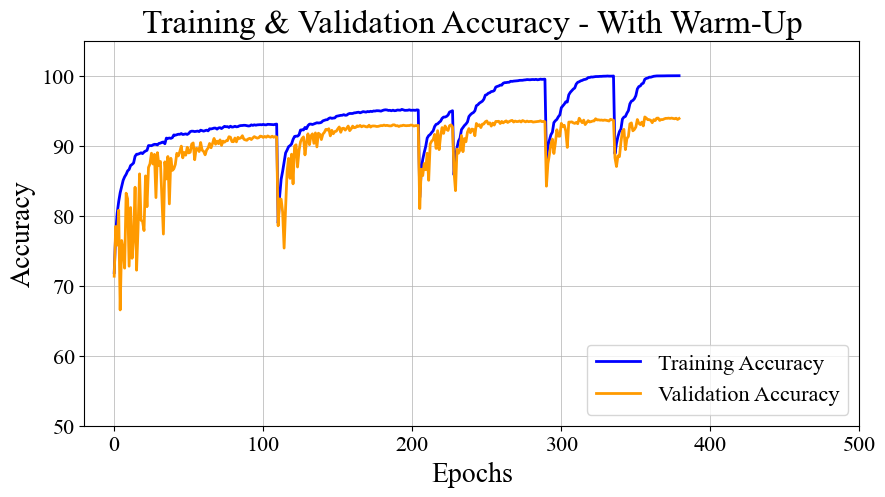

In [93]:
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 5))

plt.plot(train_accs, label="Training Accuracy", color="blue", linewidth=2.0)
plt.plot(val_accs, label="Validation Accuracy", color="#FF9A00", linewidth=2.0)

# Set font sizes for labels, title, and ticks
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Training & Validation Accuracy - With Warm-Up", fontsize=24)
plt.legend(loc="lower right", fontsize=16)

# Adjust tick font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim([50, 105])
plt.xlim([-20, 500])
# Grid
plt.grid(True, linewidth=0.5)

plt.savefig("accuracy_curves.png", dpi=300, bbox_inches='tight')
plt.show()

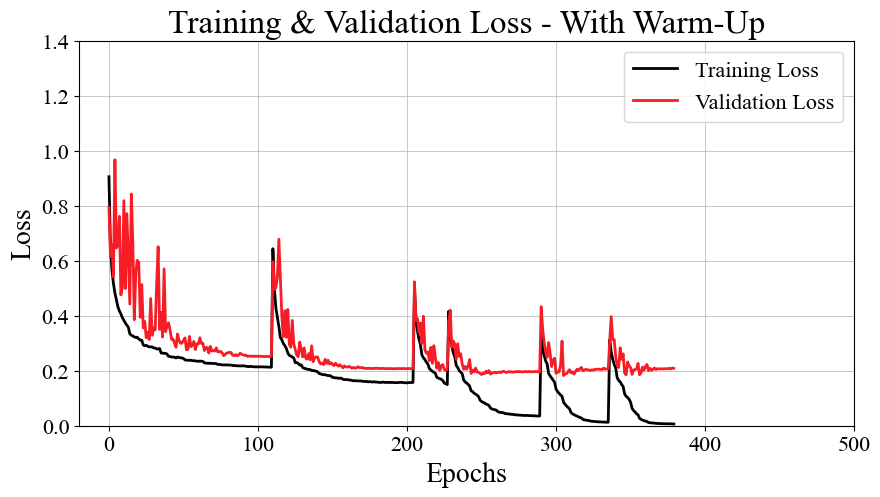

In [94]:
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 5))

plt.plot(train_losses, label="Training Loss", color="black", linewidth=2.0)
plt.plot(val_losses, label="Validation Loss", color="#F71D26", linewidth=2.0)

# Set font sizes for labels, title, and ticks
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("Training & Validation Loss - With Warm-Up", fontsize=24)
plt.legend(loc="upper right", fontsize=16)

# Adjust tick font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim([0.0, 1.4])
plt.xlim([-20, 500])
# Grid
plt.grid(True, linewidth=0.5)

plt.savefig("loss_curves.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
model = ResNet34().to(device)
model.load_state_dict(torch.load("ODN_ResNet34_Fashion_MNIST.pth", weights_only=False))

<All keys matched successfully>

In [15]:
def test_model(model, depth_level):
    model.eval()
    requires_grad_(model, False)
    test_accs = AverageMeter()
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.cuda(), labels.cuda()
        logits = model(imgs, depth_level)
        test_accs.append((logits.argmax(1) == labels).float().mean().item())
    print(f"Depth Level: {depth_level}  |  Test Accuracy: {test_accs.avg * 100:.2f} %")

In [ ]:
test_model(model, 6)

Depth Level: 6  |  Test Accuracy: 93.54 %
